In [ ]:
import gym, os
from itertools import count
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import torchvision.transforms as T
from wrappers import *

import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from PIL import Image



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("PongNoFrameskip-v4")
env = make_env(env)

state_space = env.observation_space.shape[0]
print(env.observation_space.shape)
action_space = env.action_space.n
print(action_space)

print(device)

Helper function

In [2]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 3000

def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

def get_screen(x):
    x = np.array(x)
    screen = x.transpose((2,0,1)) #(height,width,num_frames) -> (num_frames,heigth,width)
    screen = np.ascontiguousarray(screen, dtype=np.float32)/255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

Creating two seperate networks the actor and the critic

In [3]:
hidden_size = 480
num_frames = 3
end_out = 32


class Actor(nn.Module):
    def __init__(self, num_frames, h, w, outputs):
        super(Actor, self).__init__()
        self.conv1 = nn.Conv2d(num_frames, 8, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, end_out, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(end_out)
        
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * end_out
        self.out = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        #x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv1(x))
        #x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv2(x))
        #x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.conv3(x))
        x = self.out(x.view(x.size(0), -1))
        
        x = Categorical(F.softmax(x, dim=-1))
        return x

In [4]:
class Critic(nn.Module):
    def __init__(self, num_frames, h, w, outputs):
        super(Critic, self).__init__()
        self.conv1 = nn.Conv2d(num_frames, 8, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, end_out, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(end_out)
        
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * end_out
        self.out = nn.Linear(linear_input_size, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        #x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv1(x))
        #x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv2(x))
        #x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.conv3(x))
        x = self.out(x.view(x.size(0), -1))
        return x

In [5]:
learn_rate = 1e-4
n_iters = 5000
avg_over = 1

init_screen = get_screen(env.reset())
_, num_frames, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

actor = Actor(num_frames, screen_height, screen_width, n_actions).to(device)
critic = Critic(num_frames, screen_height, screen_width, n_actions).to(device)

optimizerA = optim.Adam(actor.parameters(), lr=learn_rate)
optimizerC = optim.Adam(critic.parameters(), lr=learn_rate)

score_avg = []
score_avg_all = []
a_loss = []
a_loss_avg = []
c_loss = []
c_loss_avg = []

for iter in range(n_iters):
    state = get_screen(env.reset())
    log_probs = []
    values = []
    rewards = []
    masks = []
    entropy = 0
    env.reset()
    reward_sum = 0

    for i in count():
        #env.render()
        state = torch.FloatTensor(state).to(device)
        dist, value = actor(state), critic(state)
        
        action = dist.sample()
        next_state, reward, done, _ = env.step(action.cpu().numpy())
        next_state = get_screen(next_state)
        
        reward_sum += reward
        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy += dist.entropy().mean()

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
        masks.append(torch.tensor([1-done], dtype=torch.float, device=device))

        state = next_state

        if done:
            #print('Iteration: {}, Score: {}'.format(iter, i))
            score_avg.append(reward_sum)
            break
    
        
    
    next_state = torch.FloatTensor(next_state).to(device)
    next_value = critic(next_state)
    returns = compute_returns(next_value, rewards, masks)

    log_probs = torch.cat(log_probs)
    returns = torch.cat(returns).detach()
    values = torch.cat(values)

    advantage = returns - values

    actor_loss = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()
    print('Iteration: {}, Reward: {}, Actor loss: {}, Critic Loss: {}'.format(iter, reward_sum, actor_loss, critic_loss))
    
    
    a_loss.append(actor_loss)
    c_loss.append(critic_loss)

    optimizerA.zero_grad()
    optimizerC.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    optimizerA.step()
    optimizerC.step()

Iteration: 0, Reward: -20.0, Actor loss: -3.356722116470337, Critic Loss: 3.996800184249878
Iteration: 1, Reward: -19.0, Actor loss: -2.7978880405426025, Critic Loss: 2.9295873641967773
Iteration: 2, Reward: -20.0, Actor loss: -3.423719644546509, Critic Loss: 4.686440944671631
Iteration: 3, Reward: -21.0, Actor loss: -3.835552453994751, Critic Loss: 4.885634899139404
Iteration: 4, Reward: -21.0, Actor loss: -4.31356143951416, Critic Loss: 6.118377208709717
Iteration: 5, Reward: -21.0, Actor loss: -4.187013149261475, Critic Loss: 5.753211975097656
Iteration: 6, Reward: -21.0, Actor loss: -3.6606087684631348, Critic Loss: 4.667176246643066
Iteration: 7, Reward: -19.0, Actor loss: -3.0077149868011475, Critic Loss: 3.885114908218384
Iteration: 8, Reward: -20.0, Actor loss: -3.495647430419922, Critic Loss: 4.226599216461182
Iteration: 9, Reward: -21.0, Actor loss: -4.01453971862793, Critic Loss: 5.4586286544799805
Iteration: 10, Reward: -21.0, Actor loss: -4.416629791259766, Critic Loss: 6.

Iteration: 88, Reward: -21.0, Actor loss: -0.10304460674524307, Critic Loss: 0.4399845004081726
Iteration: 89, Reward: -21.0, Actor loss: -0.8437871932983398, Critic Loss: 0.5384235382080078
Iteration: 90, Reward: -20.0, Actor loss: -0.2680921256542206, Critic Loss: 0.6497035026550293
Iteration: 91, Reward: -21.0, Actor loss: -0.4353511929512024, Critic Loss: 0.3378447890281677
Iteration: 92, Reward: -21.0, Actor loss: -0.27149298787117004, Critic Loss: 0.32622307538986206
Iteration: 93, Reward: -21.0, Actor loss: -0.2938656508922577, Critic Loss: 0.44129711389541626
Iteration: 94, Reward: -19.0, Actor loss: 0.7258095145225525, Critic Loss: 0.8158524036407471
Iteration: 95, Reward: -20.0, Actor loss: 0.25349918007850647, Critic Loss: 0.6026352643966675
Iteration: 96, Reward: -21.0, Actor loss: 0.1559489518404007, Critic Loss: 0.35327717661857605
Iteration: 97, Reward: -20.0, Actor loss: 0.48621082305908203, Critic Loss: 0.5136290192604065
Iteration: 98, Reward: -20.0, Actor loss: 0.432

KeyboardInterrupt: 

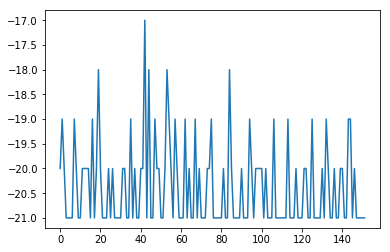

In [6]:
plt.plot(score_avg)

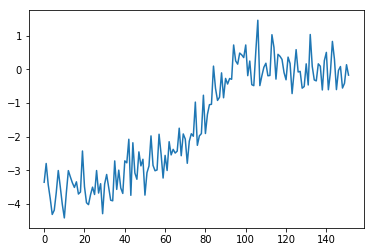

In [7]:
plt.plot(a_loss)

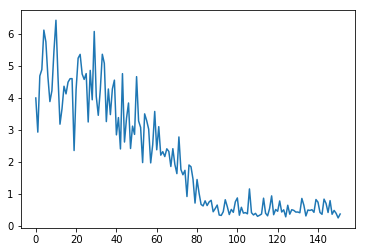

In [8]:
plt.plot(c_loss)

In [9]:
n_iter = 3
for iter in range(n_iters):
    state = get_screen(env.reset())
    log_probs = []
    values = []
    rewards = []
    masks = []
    entropy = 0
    env.reset()
    reward_sum = 0

    for i in count():
        env.render()
        state = torch.FloatTensor(state).to(device)
        dist, value = actor(state), critic(state)
        
        action = dist.sample()
        next_state, reward, done, _ = env.step(action.cpu().numpy())
        next_state = get_screen(next_state)
        
        reward_sum += reward
        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy += dist.entropy().mean()

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
        masks.append(torch.tensor([1-done], dtype=torch.float, device=device))

        state = next_state
        if done:
            break

KeyboardInterrupt: 

In [ ]:
torch.save(actor, 'results/actor.pkl')
torch.save(critic, 'results/critic.pkl')
env.close()